In [1]:
#Importing all the packages

import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series,DataFrame

In [2]:
# Specifying the Datetime 

start = datetime.datetime(2006,1,1)
end = datetime.datetime(2019,1,9)

In [3]:
# Reading data from the WEB

df = web.DataReader("AAPL", 'yahoo', start, end)
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,10.678572,10.321428,10.340000,10.678572,201808600.0,9.319328
2006-01-04,10.854285,10.642858,10.732857,10.710000,154900900.0,9.346760
2006-01-05,10.700000,10.535714,10.690000,10.625714,112355600.0,9.273201
2006-01-06,10.957143,10.650000,10.750000,10.900000,176114400.0,9.512576
2006-01-09,11.028571,10.820000,10.961429,10.864285,168760200.0,9.481407


In [4]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [5]:
mavg.tail(10)

Date
2018-12-26    201.668460
2018-12-27    201.170504
2018-12-28    200.662741
2018-12-31    200.189133
2019-01-02    199.715929
2019-01-03    199.071294
2019-01-04    198.492744
2019-01-07    197.897739
2019-01-08    197.321934
2019-01-09    196.766600
Name: Adj Close, dtype: float64

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

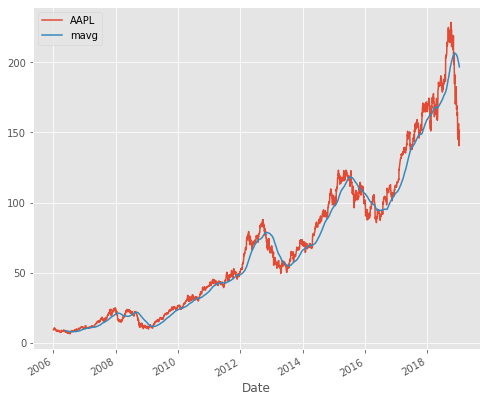

In [7]:
# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

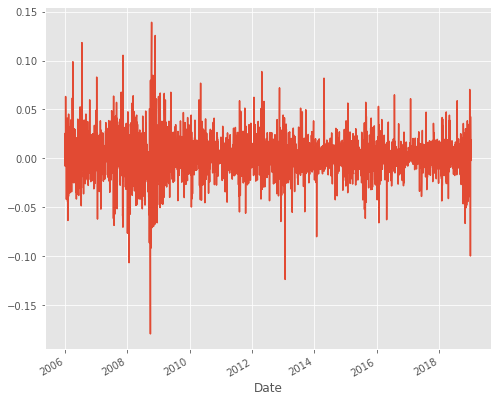

In [8]:
#Plotting the return

rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

## Feature Engineering

In [9]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [10]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2006-01-03,9.319328,201808600.0,3.344487,3.274386
2006-01-04,9.346760,154900900.0,1.974115,-0.212960
2006-01-05,9.273201,112355600.0,1.546114,-0.601359
2006-01-06,9.512576,176114400.0,2.817828,1.395345
2006-01-09,9.481407,168760200.0,1.919790,-0.886227


In [11]:
import math
import numpy as np
import preprocessing
import sklearn.preprocessing

In [14]:
forecast_col = 'Adj Close'

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)


# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)

# Separating the label here, we want to predict the AdjClose
X = np.array(dfreg.drop(['label'],1))
X = sklearn.preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out:]


dfreg.dropna(inplace=True)
y = np.array(dfreg['label'])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

In [16]:
X_train.shape

(2595, 4)

In [17]:
y_train.shape

(2595,)

In [18]:
X_test.shape

(649, 4)

In [19]:
y_test.shape

(649,)

## Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [22]:
y_pred = clfreg.predict(X_test)

In [23]:
accuracy = clfreg.score(X_test, y_test)
print(accuracy)

0.9710173301362197


In [24]:
forecast_set = clfreg.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[174.45388343 175.03472516 170.83616691 172.65830798 172.3846419
 178.65049936 177.44900399 176.61642012 182.56961377 174.67661942
 172.79717168 166.77570972 167.43205634 166.86104578 167.59657178
 169.43731699 163.9945991  162.37821451 164.7077629  159.2621472
 155.11390292 148.59770679 146.08986237 155.39593375 154.67811109
 155.06604284 156.69510565 156.7574806  140.65429342 147.05629198
 146.89306302 149.84509073 152.16472596] 0.9710173301362197 33


In [25]:
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    dfreg.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

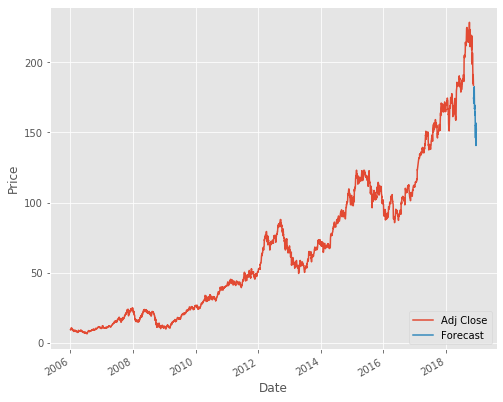

In [26]:
dfreg['Adj Close'].plot()
dfreg['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Ridge Regression

In [27]:
clf = Ridge(alpha = 0.1)
clf.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [28]:
y1_preds = clf.predict(X_test)

In [29]:
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9710171408116869


In [30]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[174.44852154 175.02976992 170.83203965 172.6534586  172.37971887
 178.64569318 177.44393472 176.61096137 182.56380415 174.67208953
 172.79231177 166.77182958 167.42783575 166.85657654 167.59183146
 169.43261826 163.99024198 162.37451575 164.70342175 159.25943137
 155.11054897 148.5945194  146.08755819 155.39427737 154.6752014
 155.06246142 156.69125344 156.75423241 140.65024052 147.05324089
 146.88938604 149.84178621 152.16168891] 0.9710171408116869 33


In [31]:
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    dfreg.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

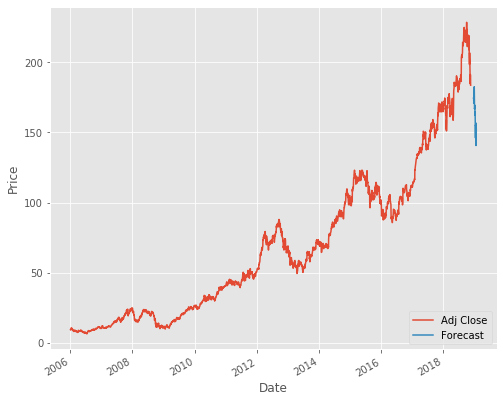

In [32]:
dfreg['Adj Close'].plot()
dfreg['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Lasso Regression

In [33]:
from sklearn import linear_model
clf1 = linear_model.Lasso(alpha=0.1)
clf1.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
y2_preds = clf1.predict(X_test)

In [35]:
accuracy = clf1.score(X_test, y_test)
print(accuracy)

0.9710236727194091


In [36]:
forecast_set = clf1.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[174.35233546 174.87143334 170.70342934 172.5308204  172.24030096
 178.55964144 177.31639186 176.4405339  182.39642258 174.57548059
 172.66494314 166.69432356 167.3802905  166.743397   167.42811497
 169.27173871 163.85474192 162.29727167 164.55523714 159.26252704
 155.08208897 148.63151894 146.03037722 155.49811639 154.65188116
 154.95427329 156.54840922 156.66953958 140.56417806 146.9966533
 146.76718715 149.72897726 152.09412373] 0.9710236727194091 33


In [37]:
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    dfreg.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

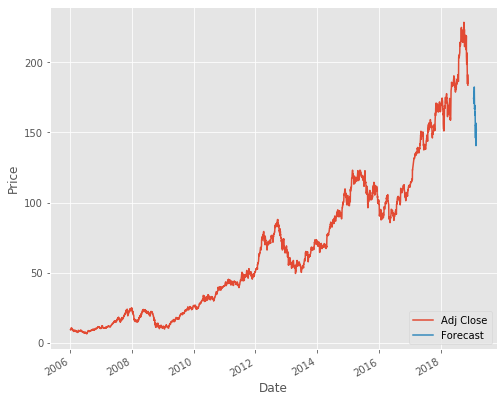

In [38]:
dfreg['Adj Close'].plot()
dfreg['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()